<a href="https://colab.research.google.com/github/ctagg11/eia_analysis/blob/main/EIA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EIA Data Analysis

PUll historical wattage data from EIA, focusing on PJM region.
Create an API key through the website https://www.eia.gov/

In [ ]:
import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import date
from google.colab import userdata
import matplotlib.dates as mdates
import numpy as np

## Pull and save API data

In [2]:
# ================= CONFIG =================
try:
    API_KEY = userdata.get('EIA_API_KEY')
except userdata.SecretNotFoundError:
    print("Error: Secret 'EIA_API_KEY' not found. Please add it to the Secrets sidebar.")
    # Allow manual input fallback if secret is missing
    API_KEY = input("Or paste your API Key here: ")

REGION = "PJM"

START_DATE = "2023-01-01T00"
END_DATE   = "2025-12-31T23"

CACHE_FILE = f"{REGION}_hourly_load_2021_2025.csv"
ROLLING_DAYS = 30


def fetch_and_cache(region, api_key):
    """Download data from EIA or load from cache if it exists."""

    if os.path.exists(CACHE_FILE):
        print("Loading data from cache...")
        df = pd.read_csv(CACHE_FILE, parse_dates=['ds'])
        return df

    print("Downloading data from EIA API...")
    all_data = []
    offset = 0

    while True:
        url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"
        params = {
            "api_key": api_key,
            "frequency": "hourly",
            "data[0]": "value",
            "facets[respondent][]": region,
            "start": START_DATE,
            "end": END_DATE,
            "sort[0][column]": "period",
            "sort[0][direction]": "asc",
            "offset": offset,
            "length": 5000
        }

        r = requests.get(url, params=params).json()
        data = r.get('response', {}).get('data', [])

        if not data:
            break

        all_data.extend(data)
        offset += 5000
        print(f"Fetched {len(all_data):,} rows...")
        time.sleep(0.2)  # avoid rate limiting

    df = pd.DataFrame(all_data)

    # Added a safety check in case the DataFrame is empty
    if df.empty:
        print("No data fetched. Check your API key or parameters.")
        return df

    df['ds'] = pd.to_datetime(df['period'])
    df['y'] = pd.to_numeric(df['value'], errors='coerce')

    df = df[(df['y'] > 65000) & (df['y'] < 170000)].dropna()

    df.to_csv(CACHE_FILE, index=False)
    print("Saved to cache.")

    return df


# ================= RUN =================
df = fetch_and_cache(REGION, API_KEY)

Fetched 5,000 rows...
Fetched 10,000 rows...
Fetched 15,000 rows...
Fetched 20,000 rows...
Fetched 25,000 rows...
Fetched 30,000 rows...
Fetched 35,000 rows...
Fetched 40,000 rows...
Fetched 45,000 rows...
Fetched 50,000 rows...
Fetched 55,000 rows...
Fetched 60,000 rows...
Fetched 65,000 rows...
Fetched 70,000 rows...
Fetched 75,000 rows...
Fetched 80,000 rows...
Fetched 85,000 rows...
Fetched 90,000 rows...
Fetched 95,000 rows...
Fetched 100,000 rows...
Fetched 104,925 rows...
Saved to cache.


## Plots

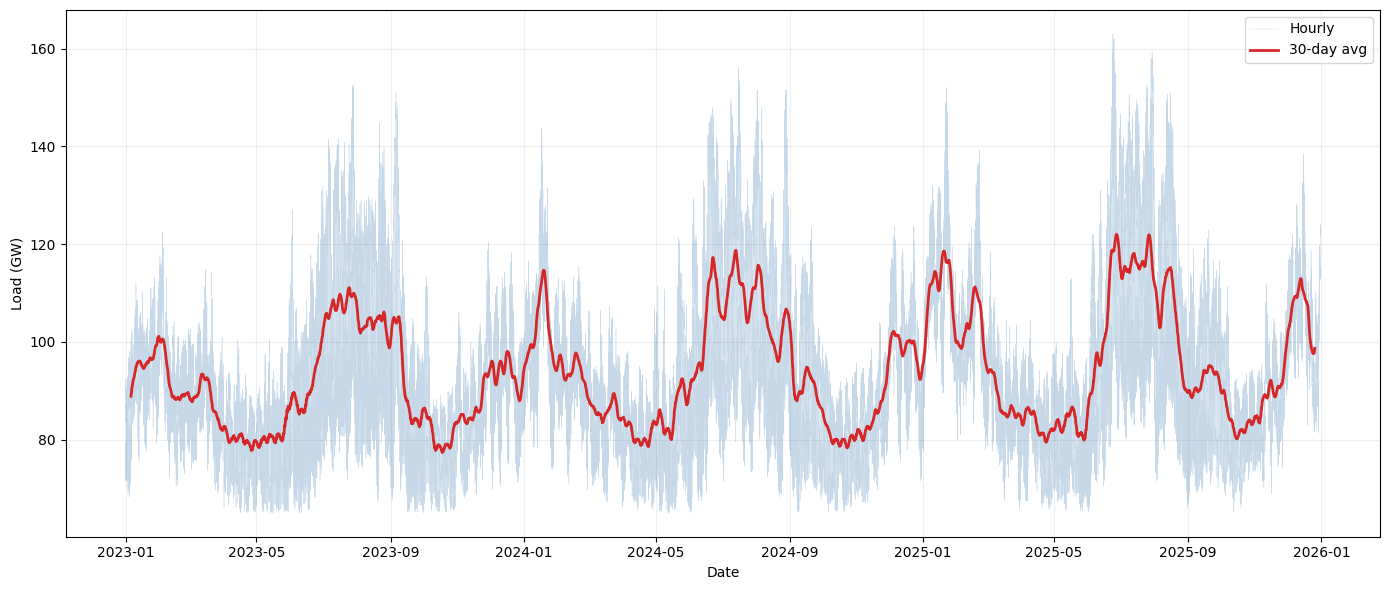

In [25]:

# First we'll show a high level overview of usage over time

df = pd.read_csv("PJM_hourly_load_2021_2025.csv", parse_dates=["ds"])

# Calculate rolling average
df['rolling_30d'] = df['y'].rolling(window=24*30, center=True).mean()

plt.figure(figsize=(14, 6))

# Convert to GW (divide by 1000)
plt.plot(df['ds'], df['y'] / 1000, linewidth=0.3, alpha=0.3, color='steelblue', label='Hourly')
plt.plot(df['ds'], df['rolling_30d'] / 1000, linewidth=2, color='#d62728', label='30-day avg')


plt.xlabel("Date")
plt.ylabel("Load (GW)")
plt.grid(alpha=0.2)

# Commas on y-axis (though less necessary now)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('PJM_demand_overview.png', dpi=150, bbox_inches='tight')
plt.show()

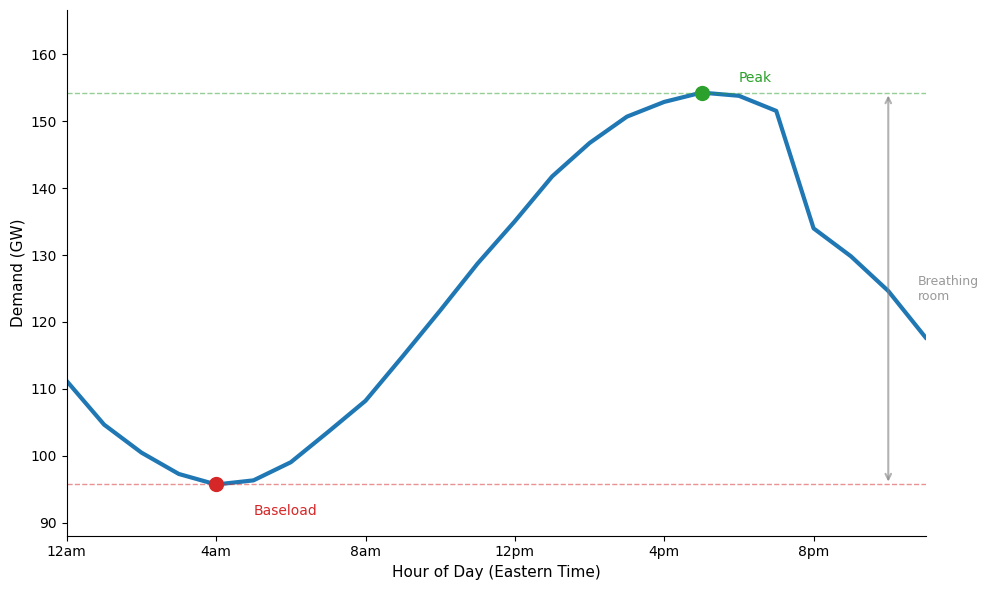

In [27]:
# show a single day of usage

def plot_single_day_breath(df, region_name, target_date=None):
    """
    Extract a single day to illustrate the 'breath' concept.
    Data is in UTC, labels converted to Eastern Time.
    """
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['hour'] = df['ds'].dt.hour
    df['date'] = df['ds'].dt.date

    daily_profiles = df.pivot_table(index='date', columns='hour', values='y').dropna()

    # Pick a good example day if not specified
    if target_date is None:
        df['month'] = df['ds'].dt.month
        df['weekday'] = df['ds'].dt.weekday
        summer_weekdays = df[(df['month'].isin([6, 7, 8])) & (df['weekday'] < 5)]['date'].unique()

        # Look for trough around hour 8-9 UTC (4-5am ET) and good amplitude
        best_date = None
        best_score = 0
        for d in summer_weekdays[:200]:
            if d in daily_profiles.index:
                day_data = daily_profiles.loc[d]
                amplitude = day_data.max() - day_data.min()
                trough_hour = day_data.values.argmin()
                if 7 <= trough_hour <= 10:  # 3-6am ET
                    if amplitude > best_score:
                        best_score = amplitude
                        best_date = d

        if best_date is None:
            best_date = summer_weekdays[10]
        target_date = best_date

    day_data = daily_profiles.loc[target_date]

    # Shift data so it starts at midnight ET (hour 4 UTC becomes hour 0)
    day_data_shifted = pd.Series(
        data=list(day_data.values[4:]) + list(day_data.values[:4]),
        index=range(24)
    )

    hours = range(24)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Main curve - convert to GW
    ax.plot(hours, day_data_shifted.values / 1000, lw=3, color='#1f77b4')

    # Mark min and max
    min_hour = day_data_shifted.values.argmin()
    max_hour = day_data_shifted.values.argmax()
    min_val = day_data_shifted.min() / 1000
    max_val = day_data_shifted.max() / 1000

    ax.plot(min_hour, min_val, 'o', markersize=10, color='#d62728', zorder=5)
    ax.plot(max_hour, max_val, 'o', markersize=10, color='#2ca02c', zorder=5)

    # Horizontal reference lines
    ax.axhline(y=min_val, linestyle='--', color='#d62728', alpha=0.5, linewidth=1)
    ax.axhline(y=max_val, linestyle='--', color='#2ca02c', alpha=0.5, linewidth=1)

    # Simple annotations
    ax.text(min_hour + 1, min_val - (max_val - min_val) * 0.05, 'Baseload',
            fontsize=10, color='#d62728', va='top')
    ax.text(max_hour + 1, max_val + (max_val - min_val) * 0.02, 'Peak',
            fontsize=10, color='#2ca02c', va='bottom')

    # Breathing room annotation
    bracket_hour = 22  # Position on right side
    ax.annotate('', xy=(bracket_hour, max_val), xytext=(bracket_hour, min_val),
                arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5, alpha=0.6))
    ax.text(bracket_hour + 0.8, (max_val + min_val) / 2, 'Breathing\nroom',
            fontsize=9, va='center', color='gray', alpha=0.8)

    ax.set_xlim(0, 23)
    ax.set_ylim(min_val * 0.92, max_val * 1.08)
    ax.set_xlabel("Hour of Day (Eastern Time)", fontsize=11)
    ax.set_ylabel("Demand (GW)", fontsize=11)


    # Now starts at midnight ET
    ax.set_xticks([0, 4, 8, 12, 16, 20])
    ax.set_xticklabels(['12am', '4am', '8am', '12pm', '4pm', '8pm'])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f'{region_name}_single_day_breath.png', dpi=150, bbox_inches='tight')
    plt.show()

    return fig

# Run it
fig = plot_single_day_breath(df, "PJM")

Saving animation... this may take a moment.


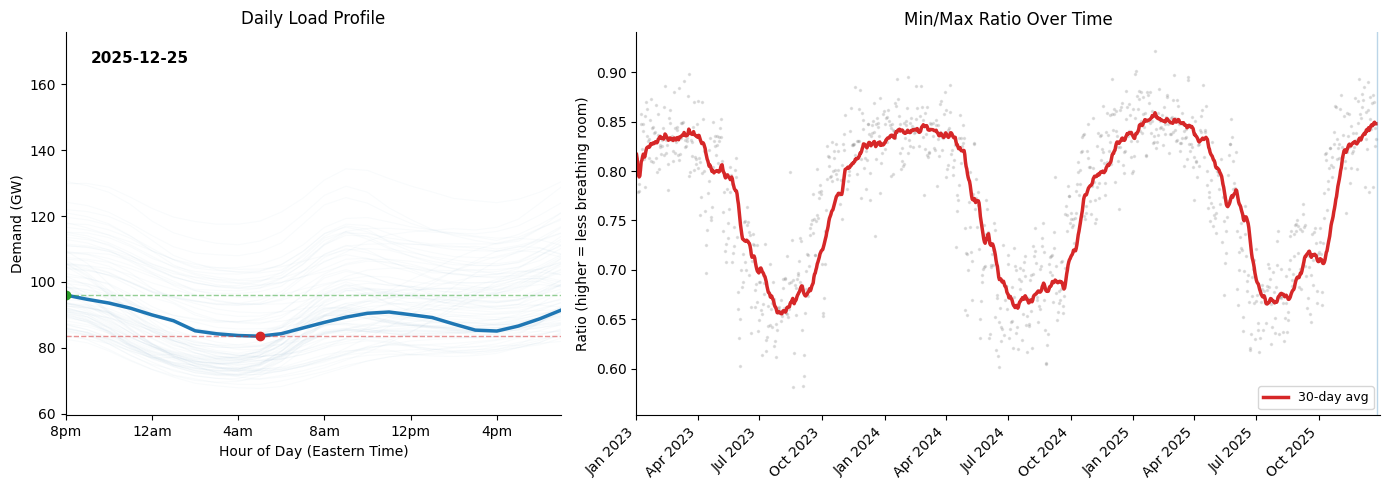

In [34]:
# animate each day
def animate_the_squeeze_v3(df, region_name, ROLLING_DAYS=30):
    # Data Preparation
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['hour'] = df['ds'].dt.hour
    df['date'] = df['ds'].dt.date

    daily_profiles = df.pivot_table(index='date', columns='hour', values='y').dropna()
    daily_min = daily_profiles.min(axis=1)
    daily_max = daily_profiles.max(axis=1)

    # The key metric
    daily_ratio = daily_min / daily_max
    rolling_ratio = daily_ratio.rolling(ROLLING_DAYS, min_periods=1).mean()

    # Convert index to datetime for proper date formatting
    date_index = pd.to_datetime(daily_profiles.index)

    # Plot Setup - two panels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.5]})

    # REMOVED TITLE
    # fig.suptitle(f"{region_name} — Grid Breathing Room", fontsize=14, fontweight='bold')

    # LEFT PANEL — Daily curve (in GW)
    ax1.set_xlim(0, 23)
    ax1.set_ylim(daily_profiles.values.min() / 1000 * 0.9,
                 daily_profiles.values.max() / 1000 * 1.1)
    ax1.set_xlabel("Hour of Day (Eastern Time)")
    ax1.set_ylabel("Demand (GW)")
    ax1.set_title("Daily Load Profile")

    # UTC -> ET labels
    ax1.set_xticks([0, 4, 8, 12, 16, 20])
    ax1.set_xticklabels(['8pm', '12am', '4am', '8am', '12pm', '4pm'])

    # INCREASED TRAILS (from 30 to 90)
    trail_len = 90
    ghosts = [ax1.plot([], [], lw=0.8, alpha=0.03, color='steelblue')[0] for _ in range(trail_len)]
    main_line, = ax1.plot([], [], lw=2.5, color='#1f77b4')
    floor_dot, = ax1.plot([], [], 'o', markersize=6, color='#d62728')
    peak_dot, = ax1.plot([], [], 'o', markersize=6, color='#2ca02c')

    floor_line = ax1.axhline(y=0, linestyle='--', linewidth=1, color='#d62728', alpha=0.5)
    ceiling_line = ax1.axhline(y=0, linestyle='--', linewidth=1, color='#2ca02c', alpha=0.5)

    date_text = ax1.text(0.05, 0.92, '', transform=ax1.transAxes, fontweight='bold', fontsize=11)

    # RIGHT PANEL — The ratio over time
    ax2.set_xlim(date_index[0], date_index[-1])
    ax2.set_ylim(daily_ratio.min() * 0.95, daily_ratio.max() * 1.02)
    ax2.set_title("Min/Max Ratio Over Time")
    ax2.set_ylabel("Ratio (higher = less breathing room)")
    ax2.set_xlabel("")

    # Format x-axis with quarterly dates
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Light scatter of daily values + rolling average trace
    ratio_scatter, = ax2.plot([], [], 'o', markersize=1.5, alpha=0.2, color='gray')
    ratio_trace, = ax2.plot([], [], lw=2.5, color='#d62728', label=f'{ROLLING_DAYS}-day avg')

    # REMOVED TREND LINE PLOT HERE

    ax2.legend(loc='lower right', fontsize=9)

    # Vertical line showing current position
    current_line = ax2.axvline(x=date_index[0], color='#1f77b4', alpha=0.3, linewidth=1)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()

    # INCREASED SPEED: STEP SIZE 5
    step_size = 5

    def animate(i):
        idx = i * step_size
        if idx >= len(daily_profiles):
            return []

        y_vals = daily_profiles.iloc[idx].values / 1000  # Convert to GW
        d_min = daily_min.iloc[idx] / 1000
        d_max = daily_max.iloc[idx] / 1000
        hours = range(24)

        # Update ghosts
        for j in range(trail_len):
            hist_idx = idx - j
            if hist_idx >= 0:
                ghosts[j].set_data(hours, daily_profiles.iloc[hist_idx].values / 1000)
            else:
                ghosts[j].set_data([], [])

        # Update main curve & markers
        main_line.set_data(hours, y_vals)
        min_hour = y_vals.argmin()
        max_hour = y_vals.argmax()
        floor_dot.set_data([min_hour], [d_min])
        peak_dot.set_data([max_hour], [d_max])

        floor_line.set_ydata([d_min, d_min])
        ceiling_line.set_ydata([d_max, d_max])

        # Update ratio panel - traces build over time
        ratio_scatter.set_data(date_index[:idx], daily_ratio.iloc[:idx])
        ratio_trace.set_data(date_index[:idx], rolling_ratio.iloc[:idx])

        # Update current position line
        current_line.set_xdata([date_index[idx], date_index[idx]])

        # Update date text
        current_date = daily_profiles.index[idx]
        date_text.set_text(f"{current_date}")

        return [main_line, floor_dot, peak_dot, ratio_scatter, ratio_trace,
                current_line, date_text] + ghosts

    ani = FuncAnimation(fig, animate, frames=len(daily_profiles)//step_size, interval=30, blit=False)

    print("Saving animation... this may take a moment.")
    ani.save(f'{region_name}_grid_squeeze_v3.gif', writer='pillow', fps=25)
    plt.show()

    return fig, ani

# Run it
fig, ani = animate_the_squeeze_v3(df, "PJM")

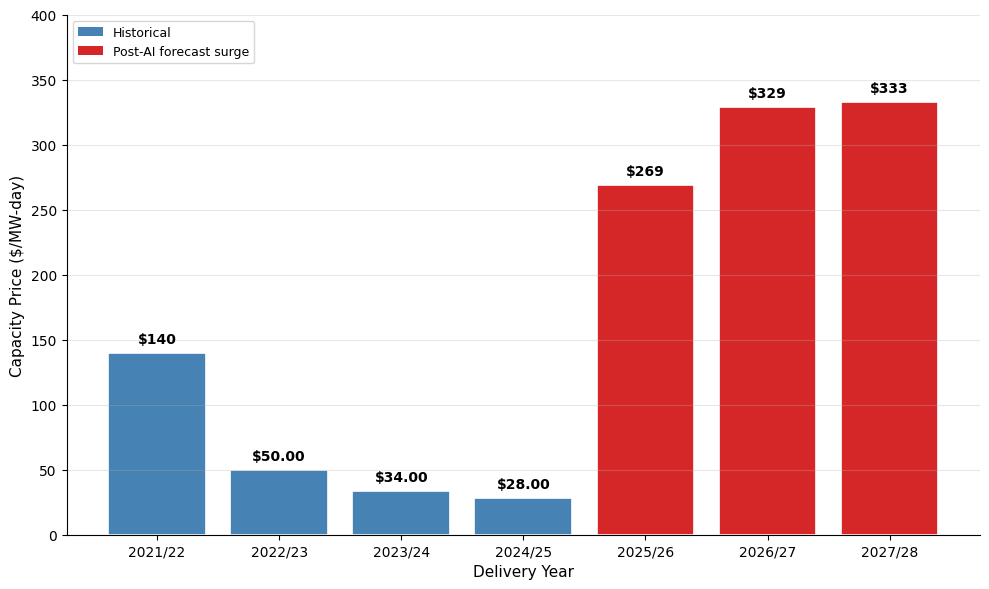

In [33]:
# PJM RTO Capacity Auction Clearing Prices ($/MW-day)
delivery_years = [
    '2021/22', '2022/23', '2023/24', '2024/25',
    '2025/26', '2026/27', '2027/28'
]
prices = [140, 50, 34, 28, 269, 329, 333]

# Color: blue for historical (already delivered or delivering), orange for forward
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue',
          '#d62728', '#d62728', '#d62728']

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(delivery_years, prices, color=colors, edgecolor='white', linewidth=1.2)

# Add value labels on bars
for bar, price in zip(bars, prices):
    height = bar.get_height()
    ax.annotate(f'${price:.0f}' if price > 50 else f'${price:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')



ax.set_ylabel('Capacity Price ($/MW-day)', fontsize=11)
ax.set_xlabel('Delivery Year', fontsize=11)


# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Historical'),
                   Patch(facecolor='#d62728', label='Post-AI forecast surge')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

ax.set_ylim(0, 400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('PJM_capacity_prices.png', dpi=150, bbox_inches='tight')
plt.show()